In [ ]:
## Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar el archivo desde Google Drive
import pandas as pd

file_path =  "/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx"

# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)

In [ ]:
!pip uninstall -y cupy


**Entrena el modelo**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier

# 🔒 Asegurar reproducibilidad total
np.random.seed(42)


# ✅ Características seleccionadas
columnas_seleccionadas = [
    'POS', 'NEU', 'NEG', 'tristeza', 'miedo', 'disgusto', 'enojo', 'sorpresa', 'alegria',
     'toxicity',
    'me', 'mi', 'yo',
   # 'mí',
    'num_palabras_mayusculas',
    'num_palabras_largas',
  # 'num_signos_puntuacion',
    'negaciones',
    'falta de motivacion',
   'aislamiento social',
    'pensamientos suicidas',
   # 'baja autoestima',
  #  'insomnio',
   # 'ataques de panico',
    #'pensamientos acelerados'

]

# ⚙️ Normalización de variables numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = ['num_palabras_largas', 'num_palabras_mayusculas', 'num_signos_puntuacion']
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# 📦 Separar variables independientes y dependiente
X = df[columnas_seleccionadas]
y = LabelEncoder().fit_transform(df['label'])  # Asegurarse que contenga [0, 1, 2]

# ✂️ División estratificada
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

# 🧠 Modelo con hiperparámetros definidos (config base)
model = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    boosting_type='gbdt',
    n_estimators=100,
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.7,
    verbosity=-1,
    random_state=42,
    class_weight='balanced'

)


# 🚀 Entrenamiento
model.fit(X_train, y_train)

# 🔍 Predicción
y_pred = model.predict(X_test)

# 📊 Métricas
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy:  0.8219
Precision: 0.8226
Recall:    0.8219
F1-Score:  0.8222
Confusion Matrix:
 [[65  9  2]
 [ 9 40  2]
 [ 1  3 15]]


**Busqueda de mejores hiperparametros**

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'feature_fraction': [0.8, 0.7, 0.6],
   'random_state':[42],
    'num_class': [len(set(y_train))],  # Número de clases en el conjunto de datos
}

# Inicializar el modelo LGBM
lgbm = LGBMClassifier()

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='f1_weighted',  # Métrica de evaluación
    verbose=1
)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y la mejor puntuación
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor F1 Score obtenido en validación cruzada:", grid_search.best_score_)

# Obtener el mejor modelo ajustado
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros encontrados: {'boosting_type': 'gbdt', 'feature_fraction': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'num_class': 3, 'num_leaves': 31, 'objective': 'multiclass', 'random_state': 42}
Mejor F1 Score obtenido en validación cruzada: 0.7276660464706078
Accuracy: 0.7877
Precision: 0.7863
Recall: 0.7877
F1-Score: 0.7868
Confusion Matrix:
[[65  9  2]
 [11 37  3]
 [ 2  4 13]]


**Validacion cruzada**

In [ ]:
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

# Inicializar el modelo LGBM
lgbm_best = LGBMClassifier(
 objective='multiclass',
    num_class=3,
    boosting_type='gbdt',
    n_estimators=100,
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42
)

# Configurar métricas para la validación cruzada
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Realizar validación cruzada con múltiples métricas
cv_results = cross_validate(lgbm_best, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=False)

# Calcular promedios y desviaciones estándar
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision_weighted'].mean()
std_precision = cv_results['test_precision_weighted'].std()
mean_recall = cv_results['test_recall_weighted'].mean()
std_recall = cv_results['test_recall_weighted'].std()
mean_f1 = cv_results['test_f1_weighted'].mean()
std_f1 = cv_results['test_f1_weighted'].std()

# Mostrar resultados
print("Resultados de Validación Cruzada con los Mejores Hiperparámetros para LGBM:")
print(f"Accuracy Promedio: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision Promedio: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall Promedio: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1 Score Promedio: {mean_f1:.4f} ± {std_f1:.4f}")


Resultados de Validación Cruzada con los Mejores Hiperparámetros para LGBM:
Accuracy Promedio: 0.6754 ± 0.0749
Precision Promedio: 0.6852 ± 0.0748
Recall Promedio: 0.6754 ± 0.0749
F1 Score Promedio: 0.6728 ± 0.0747


<Figure size 1000x600 with 0 Axes>

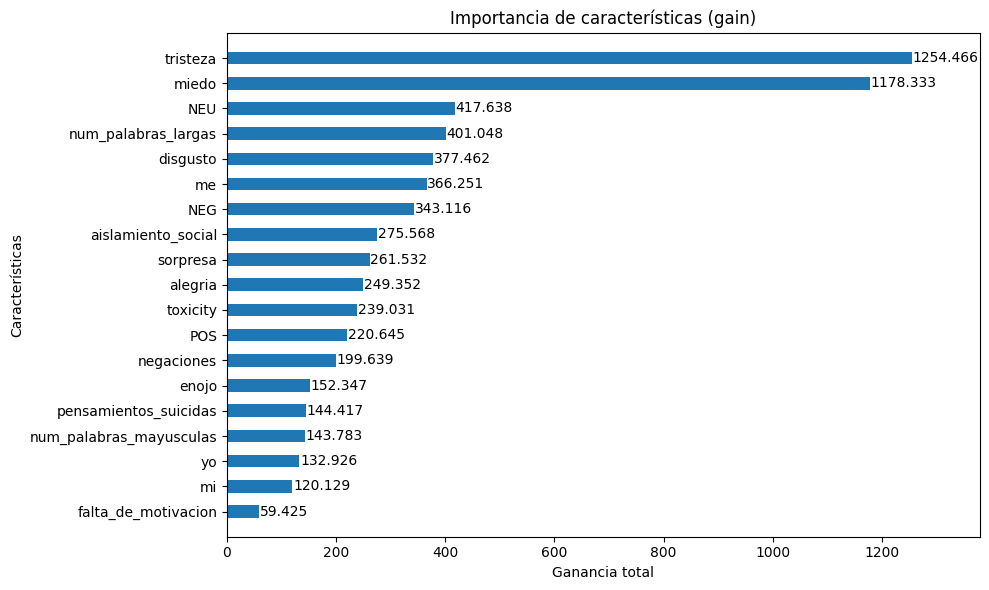

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Parámetros para estilo de gráfico
plt.figure(figsize=(10, 6))
ax = lgb.plot_importance(
    model,
    max_num_features=20,           # Top 20 características
    importance_type='gain',        # Importancia basada en ganancia
    height=0.5,                    # Altura de cada barra
    figsize=(10, 6),
    title='Importancia de características (gain)',
    xlabel='Ganancia total',
    ylabel='Características',
    grid=False
)
plt.tight_layout()
plt.show()
